In [1]:
from model import UNet
from dataset2d import Dataset2D
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from imageio import imwrite
from PIL import Image
import model_hyper_parameters as config
from tqdm.auto import tqdm
from torchvision import transforms

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.normalization=nn.Softmax(dim=1)

    def forward(self, inputs, targets, smooth=1e-4):
        inputs = self.normalization(inputs)

        targets = targets[:, 1:2, ...]
        inputs = torch.where(inputs[:, 1:2, ...] > 0.5, 1.0, 0.0)

        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return dice
    
def calculate_IoU(outputs, masks):
    predicted_masks = (outputs > 0.5).float()
    intersection = torch.sum(predicted_masks * masks)
    union = torch.sum(predicted_masks) + torch.sum(masks) - intersection
    iou = (intersection + 1e-8)/ (union + 1e-8)
    return iou

In [3]:
DEFAULT_KIDNEY_COLOR = [255, 0, 0]
DEFAULT_PRED_COLOR = [0, 0, 255]
ALPHA = 0.3
dicescore=DiceScore()
os.makedirs('pred_img',exist_ok=True)

In [4]:
model = UNet(64,5,use_xavier=True,use_batchNorm=True,dropout=0.5,retain_size=True,nbCls=1)
# devices = 'cpu'
# device_num = 0
# if torch.cuda.is_available():
#     devices = 'gpu'
#     device_num = torch.cuda.device_count()
# unet = torch.nn.DataParallel(unet)
DEVICE = torch.device("cuda:1")
model.to(DEVICE)
if torch.cuda.is_available():
    print('CUDA Available!')
    model.load_state_dict(torch.load('./final_result/best_model.pt'))
else:
    print('CUDA is unavailable, using CPU instead!')
    print('Warning: using CPU might require several hours')
    model.load_state_dict(torch.load('./final_result/unet.pt', map_location=torch.device('cpu')))

CUDA Available!


In [5]:
# make dataLoader
base_path = '/scratch/student/sinaziaee/datasets/2d_dataset/'
# base_path = 'new_3d_dataset'
test_dir = os.path.join(base_path, 'testing')

transformer = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = Dataset2D(input_root=f'{test_dir}/images/', target_root=f'{test_dir}/labels/', transform= transformer)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=config.PIN_MEMORY)

In [6]:
def show_image_modified(image, mask, pred_image=None, path_dir=None, filename=None, iou=None, dice_score=None):
    image = image.squeeze()  # Remove channel dimension if it's present
    mask = mask.squeeze()  # Remove channel dimension if it's present

    plt.figure(figsize=(10, 5))

    if pred_image is not None:
        ax1 = plt.subplot(1, 3, 1)
        ax2 = plt.subplot(1, 3, 2)
        ax3 = plt.subplot(1, 3, 3)
    else:
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2)

    ax1.set_title('IMAGE')
    ax1.imshow(image, cmap='gray')
    ax1.axis('off')

    ax2.set_title('GROUND TRUTH')
    ax2.imshow(mask, cmap='gray')
    ax2.axis('off')

    # Add IoU and Dice score to the predicted image subplot
    if pred_image is not None and iou is not None and dice_score is not None:
        pred_image = pred_image.squeeze()  # Remove channel dimension if it's present
        ax3.imshow(pred_image, cmap='gray')
        ax3.set_title('MODEL OUTPUT')
        ax3.axis('off')
        ax3.text(5, 5, f'IoU: {iou:.2f}, Dice: {dice_score:.2f}', color='white', fontsize=8, backgroundcolor='black')

    if path_dir is not None and filename is not None:
        full_path = os.path.join(path_dir, filename)
        plt.savefig(full_path, bbox_inches='tight', pad_inches=0)

    plt.close()

KeyboardInterrupt: 

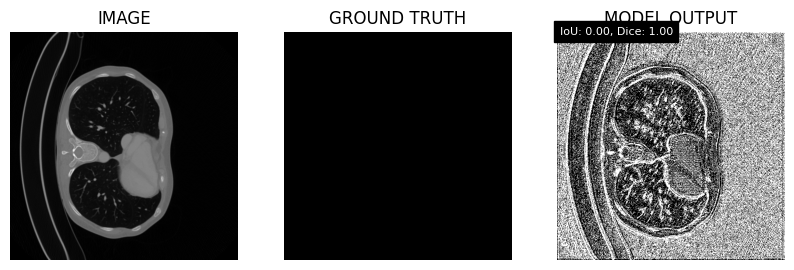

In [10]:
total_iou = 0.0
total_dice = 0.0
num_images = 0

for idx, (images, true_masks) in enumerate(test_loader):
    images = images.to(DEVICE)
    true_masks = true_masks.to(DEVICE)
    
    # filename = test_loader.dataset.get_filename(idx)

    with torch.no_grad():
        logits_mask = model(images)
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > 0.5) * 1.0

    # Calculate IoU and Dice Score for each image
    iou = calculate_IoU(pred_mask, true_masks)
    dice_score = dicescore(pred_mask, true_masks)

    total_iou += iou.item()
    total_dice += dice_score
    num_images += 1

    # Move tensors to CPU
    images_cpu = images[0].detach().cpu().squeeze()
    true_masks_cpu = true_masks[0].detach().cpu().squeeze()
    pred_mask_cpu = pred_mask[0].detach().cpu().squeeze()

    # Use the modified show_image function
    show_image_modified(images_cpu, true_masks_cpu, pred_mask_cpu, 
            path_dir='./pred_img/', filename=str(idx), iou=iou, dice_score=dice_score)

overall_iou = total_iou / num_images
overall_dice = total_dice / num_images
print(f"Overall IoU: {overall_iou:.2f}, Overall Dice Score: {overall_dice:.2f}")

In [7]:
# total_dice = 0
# total_loss = 0
# counter = 0
# softmax=nn.Softmax(dim=1)

# num_test = int(len(test_loader) // config.BATCH_SIZE)
# test_loop = tqdm(range(num_test), leave=False, position=0)

# data_iter = iter(test_loader)

# with torch.no_grad():
#     for i in test_loop:
#         model.eval()
#         counter += 1
#         (x, y) = next(data_iter)
#         x = x.to(DEVICE)    
#         pred = model(x)
#         pred=pred.cpu()
        
#         dice=dicescore(pred.clone(), y.clone())
#         total_dice+=dice
        
#         img_np=x.cpu().numpy()
#         seg_np=y.cpu().numpy()
        
#         img_np=img_np.reshape((1,512,512))
#         seg_np=seg_np.reshape((1,512,512))
        
#         img=255*img_np
#         img=np.stack((img,img,img),axis=-1)
        
#         shp=seg_np.shape
#         seg_color=np.zeros((shp[0],shp[1],shp[2],3),dtype=np.float32)
#         seg_color[np.equal(seg_np,1)]=DEFAULT_KIDNEY_COLOR
#         seg_color[np.equal(pred,1)]=DEFAULT_PRED_COLOR
        
#         img.astype(np.uint8)
#         seg_color.astype(np.uint8)
#         seg_np.astype(np.uint8)
        
#         segbin1=np.greater(seg_np,0)
#         segbin2=np.greater(pred,0)
        
#         segbin = np.concatenate((segbin1 * 0.5, segbin2 * 0.5), axis=0)        
#         r_segbin=np.stack((segbin,segbin,segbin),axis=-1)
#         overlayed=np.where(
#             r_segbin,
#             np.round(ALPHA*seg_color+(1-ALPHA)*img).astype(np.uint8),
#             np.round(img).astype(np.uint8))
#         imwrite('./pred_img/'+'{:05d}_{:.2f}%.png'.format(i,dice*100),overlayed[0])
# print('Image Generated Finished, Average F1 Score: {:.3f}%'.format((total_dice/counter)*100))

  0%|          | 0/132 [00:00<?, ?it/s]